### Урок 4. Деревья решений

# Домашнее задание

#### 1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [2]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=5)

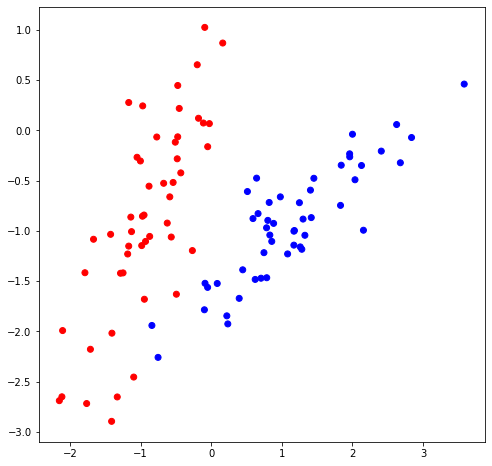

In [3]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [4]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [5]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels  # y_true
        self.prediction = self.predict()  # y_pred
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [6]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1     # "impurity" - "нечистота", степень неопределенности
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [7]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выборки, ушедшей в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [8]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [9]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels, one_class):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    # Если все объекты относятся к одному классу
    if one_class == True and current_gini == 0:
        return best_quality, best_t, best_index
    
    n_features = data.shape[1]
    
    
    for index in range(n_features):
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [10]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, max_leafs, max_depth, one_class):
    quality, t, index = find_best_split(data, labels, one_class)
    # При каждом вызове уменьшаем глубину дерева
    max_depth -= 1

    # Базовый случай - прекращаем рекурсию, когда нет прироста в качества 
    # или когда глубина дерева закончилась или когда остался последний лист 
    # или когда все объекты в листе относятся к одному классу
    if quality == 0 or max_depth == 0 or max_leafs == 1 or quality == 1:
        max_leafs -= 1
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
        
    # Заранее предполагаем, что второй узел будет иметь как минимум 1 лист
    max_leafs -= 1

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, max_leafs, max_depth, one_class)
    false_branch = build_tree(false_data, false_labels, max_leafs, max_depth, one_class)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [11]:
# Проход объекта по дереву для его классификации

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [12]:
# Предсказание деревом для всего датасета

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [13]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [14]:
# Построим дерево по обучающей выборке
# max_leafs - Останов по максимальному количеству листьев
# max_depth - Останов по максимальной глубине дерева
# one_class - Останов в случае, когда все объекты в листе относятся к одному классу
my_tree = build_tree(train_data, train_labels, max_leafs=4, max_depth=3, one_class=True)

In [15]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 0
Порог 0.16261402870113306
--> True:
  Индекс 1
  Порог -1.5208896621663803
  --> True:
    Прогноз: 0
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1


In [16]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [17]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [18]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [19]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

92.85714285714286

In [20]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

96.66666666666667

Text(0.5, 1.0, 'Test accuracy=96.67')

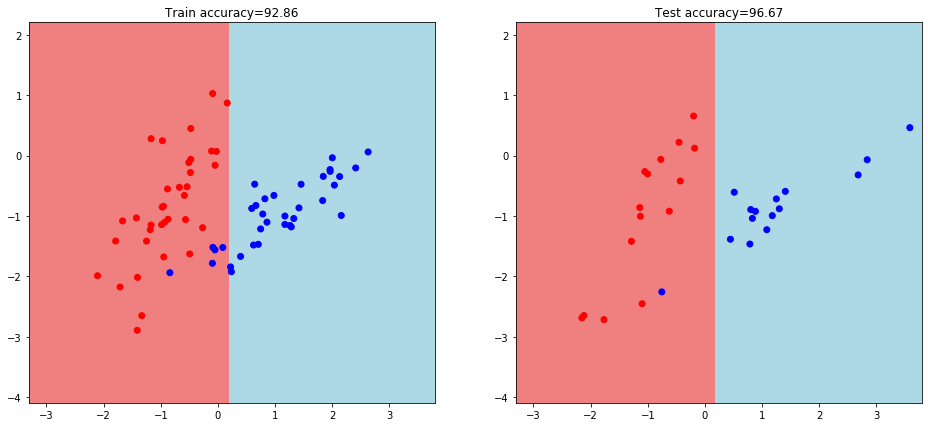

In [21]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

#### 2*. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [22]:
from sklearn.metrics import r2_score

In [23]:
# сгенерируем данные
X, Y = datasets.make_regression(n_features = 2, n_informative = 1, noise=10, random_state=10)

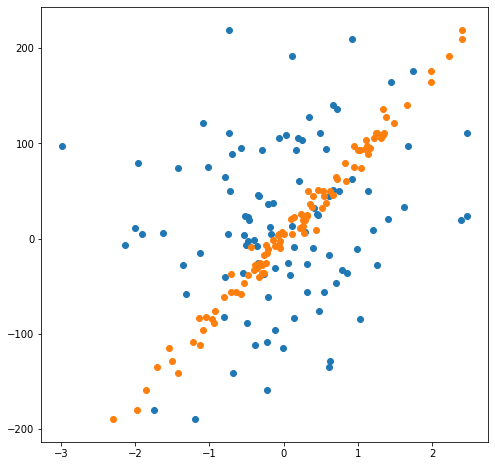

In [24]:
# визуализируем сгенерированные данные

plt.figure(figsize=(8,8))
plt.scatter(X[:,0], Y)
plt.scatter(X[:,1], Y)
plt.show()

In [25]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [26]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels  # y_true
        self.prediction = self.predict()  # y_pred
        
    def predict(self):
        return np.mean(self.labels)

In [27]:
# Расчет критерия для регрессии

def get_h(y):
    return np.var(y)

In [28]:
# Расчет качества

def quality(left_labels, right_labels, current_h):

    # доля выборки, ушедшей в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_h - p * get_h(left_labels) - (1 - p) * get_h(right_labels)

In [29]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [30]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels, one_value):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    h = get_h(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    # Если все объекты с одним значением
    if one_value == True and h == 0:
        return best_quality, best_t, best_index
    
    n_features = data.shape[1]
    
    
    for index in range(n_features):
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, h)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [31]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, max_leafs, max_depth, one_value):
    quality, t, index = find_best_split(data, labels, one_value)
    # При каждом вызове уменьшаем глубину дерева
    max_depth -= 1

    # Базовый случай - прекращаем рекурсию, когда нет прироста в качества 
    # или когда глубина дерева закончилась или когда остался последний лист 
    # или когда все объекты в листе относятся к одному классу
    if quality == 0 or max_depth == 0 or max_leafs == 1 or quality == 1:
        max_leafs -= 1
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
        
    # Заранее предполагаем, что второй узел будет иметь как минимум 1 лист
    max_leafs -= 1

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, max_leafs, max_depth, one_value)
    false_branch = build_tree(false_data, false_labels, max_leafs, max_depth, one_value)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [32]:
# Проход объекта по дереву для его классификации

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [33]:
# Предсказание деревом для всего датасета

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [34]:
# Разобьем выборку на обучающую и тестовую

train_x, test_x, train_y, test_y = model_selection.train_test_split(X, Y, test_size = 0.3, random_state = 1)

In [35]:
# Построим дерево по обучающей выборке
# max_leafs - Останов по максимальному количеству листьев
# max_depth - Останов по максимальной глубине дерева
# one_value - Останов в случае, когда все объекты в листе одинаковые
my_tree = build_tree(train_x, train_y, max_leafs=10, max_depth=10, one_value=True)

In [36]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 1
Порог 0.5484280662958247
--> True:
  Индекс 1
  Порог -0.8045911422699545
  --> True:
    Индекс 1
    Порог -1.4208805151542343
    --> True:
      Прогноз: -145.82707294353855
    --> False:
      Прогноз: -88.7711436968937
  --> False:
    Индекс 1
    Порог -0.11227247119416003
    --> True:
      Индекс 1
      Порог -0.2876294136505807
      --> True:
        Индекс 0
        Порог 0.08958761258951613
        --> True:
          Прогноз: -40.11678880977987
        --> False:
          Прогноз: -29.930175233408175
      --> False:
        Прогноз: -12.15580305021531
    --> False:
      Индекс 1
      Порог 0.2730493200953109
      --> True:
        Индекс 1
        Порог 0.004291430934033236
        --> True:
          Прогноз: 1.7661647543130243
        --> False:
          Прогноз: 13.356662853834582
      --> False:
        Индекс 0
        Порог 0.4609029016717183
        --> True:
          Прогноз: 27.186252810663063
        --> False:
          Прогноз: 35.5678228

In [37]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_x, my_tree)

In [38]:
# И получим ответы для тестовой выборки
answers = predict(test_x, my_tree)

In [39]:
# R2 на обучающей выборке
train_accuracy = r2_score (train_y, train_answers)
train_accuracy

0.9765875082320195

In [40]:
# R2 на тестовой выборке
test_accuracy = r2_score (test_y, answers)
test_accuracy

0.9190722253103285

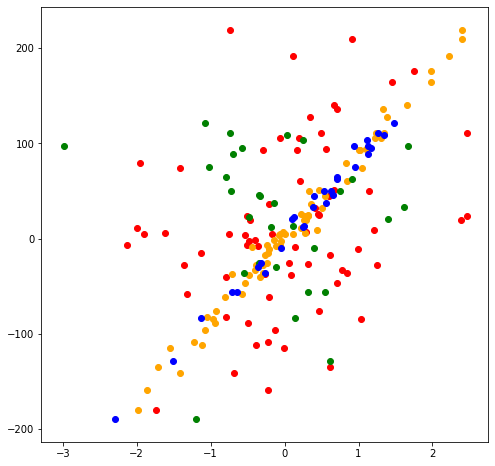

In [41]:
plt.figure(figsize=(8,8))
plt.scatter(train_x[:,0], train_y, c="Red")
plt.scatter(train_x[:,1], train_y, c="Orange")
plt.scatter(test_x[:,0], test_y, c="Green")
plt.scatter(test_x[:,1], test_y, c="Blue")
plt.show()